## Glue Studio Taxi Demo

In this demo we will load NYC taxi information into S3 and populate the Glue Data Catalog. Once the catalog is populated with the source tables we will use features in Glue Studio to visually create parquet formatted data denormalized into a curated data set.

We will be using the Python boto3 library for parts of the demo and resources created from scripts executed in CloudFormation leveraging the CDK. To get started with this demo review the [README.md](README.md) file.

You can find more information about the Python `boto3` library [here](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html)

In [ ]:
import boto3
import botocore
import json
import os
import uuid
import pandas as pd

glue = boto3.client('glue')
s3 = boto3.resource('s3')
s3_client = boto3.client('s3')
lf = boto3.client('lakeformation')
cfn = boto3.client('cloudformation')

session = boto3.session.Session()
region = session.region_name
account_id = boto3.client('sts').get_caller_identity().get('Account')

#### Get the Outputs from the CloudFormation template

The `GlueStudioDemoStack` needs to be executed before starting the demo. From this repo you can run the commands in the root directory below to get started if you just came to the notebook. To launch the CloudFormation script this requires the [AWS Cloud Development Kit](https://aws.amazon.com/cdk/)(CDK). The CDK synthizes CloudFormation templates written in `TypeScript` for this demo but other languages are supported. For more information on the CDK API go [here](https://docs.aws.amazon.com/cdk/api/latest/docs/aws-construct-library.html).

From the root directory:

``` bash
npm install

cdk deploy
```

Once this is deployed sucecssfully you will be able to get the `Outputs` from the CloudFormation stack. It creates the resources below:

* S3 Bucket
* IAM Role
* Glue Database
* Glue Crawler

These resources will be used throughout the demo to store files, provide access to the data lake, and populate the catalog to be used by Glue Studio.

In [ ]:
response = cfn.describe_stacks(
    StackName='GlueStudioDemoStack'
)

outputs = response['Stacks'][0]['Outputs']

for output in outputs:
    if (output['OutputKey'] == 'DataLakeBucketName'):
        bucket = output['OutputValue']
    if (output['OutputKey'] == 'TaxiDatabase'):
        database_name = output['OutputValue']
    if (output['OutputKey'] == 'DataLakeRoleArn'):
        role_arn = output['OutputValue']
    if (output['OutputKey'] == 'TaxiDataCrawler'):
        data_crawler = output['OutputValue']        
        
pd.set_option('display.max_colwidth', None)
pd.DataFrame(outputs, columns=["OutputKey", "OutputValue"])

### Upload data files to S3

Next, we will upload the `.csv` files located in the `data` folder to S3 to be used later in the demo. We are using a sample file from New York City Taxi and Limousine Commission (TLC) Trip Record Data dataset available on the [AWS Open Data Registry](https://registry.opendata.aws/nyc-tlc-trip-records-pds/).

[s3.upload_file](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/s3.html#S3.Client.upload_file) boto3 documentation

In [ ]:
file_name = 'yellow_tripdata_2020-06.csv'
path = 'data'
session.resource('s3').Bucket(bucket).Object(os.path.join('datalake', 'yellow', file_name)).upload_file(path + '/' + file_name)

file_name = 'paymenttype.csv'
path = 'data'
session.resource('s3').Bucket(bucket).Object(os.path.join('datalake', 'paymenttype', file_name)).upload_file(path + '/' + file_name)

file_name = 'ratecode.csv'
session.resource('s3').Bucket(bucket).Object(os.path.join('datalake', 'ratecode', file_name)).upload_file(path + '/' + file_name)

file_name = 'taxi_zone_lookup.csv'
session.resource('s3').Bucket(bucket).Object(os.path.join('datalake', 'taxi_zone_lookup', file_name)).upload_file(path + '/' + file_name)

#### Load Taxi Demo database with S3 data from Glue Crawler

**TODO**


In [ ]:
glue.start_crawler(Name=data_crawler)

crawler_status = glue.get_crawler(Name=data_crawler)['Crawler']['State']

while crawler_status not in ('READY'):
    crawler_status = glue.get_crawler(Name=data_crawler)['Crawler']['State']
    print(crawler_status)
    time.sleep(30)
    
print('Crawler Complete')

#### View Crawler Results

Now that we have crawled the taxi data, we want to look at the results of the crawl to see the tables that were created. We will call the [glue.get_tables](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/glue.html#Glue.Client.get_tables) function and load key fields into a pandas DataFrame for display.

In [ ]:
df = pd.json_normalize(glue.get_tables(DatabaseName=database_name)['TableList'])
pd.set_option('display.max_colwidth', None)
pd.DataFrame(df, columns=["Name", "DatabaseName", "StorageDescriptor.Columns", "StorageDescriptor.Location"])

#### Let's start with Glue Studio

Run the cell below to take you to the Glue Studio console and use the instructions below to create the Glue Job visually. We will be joining multiple tables from the Glue Data Catalog into a single data set and save it to the S3 bucket created earlier in Parquet format. Later, we will use the job created with Glue Studio in a Glue Workflow to create and end-to-end ETL solution. 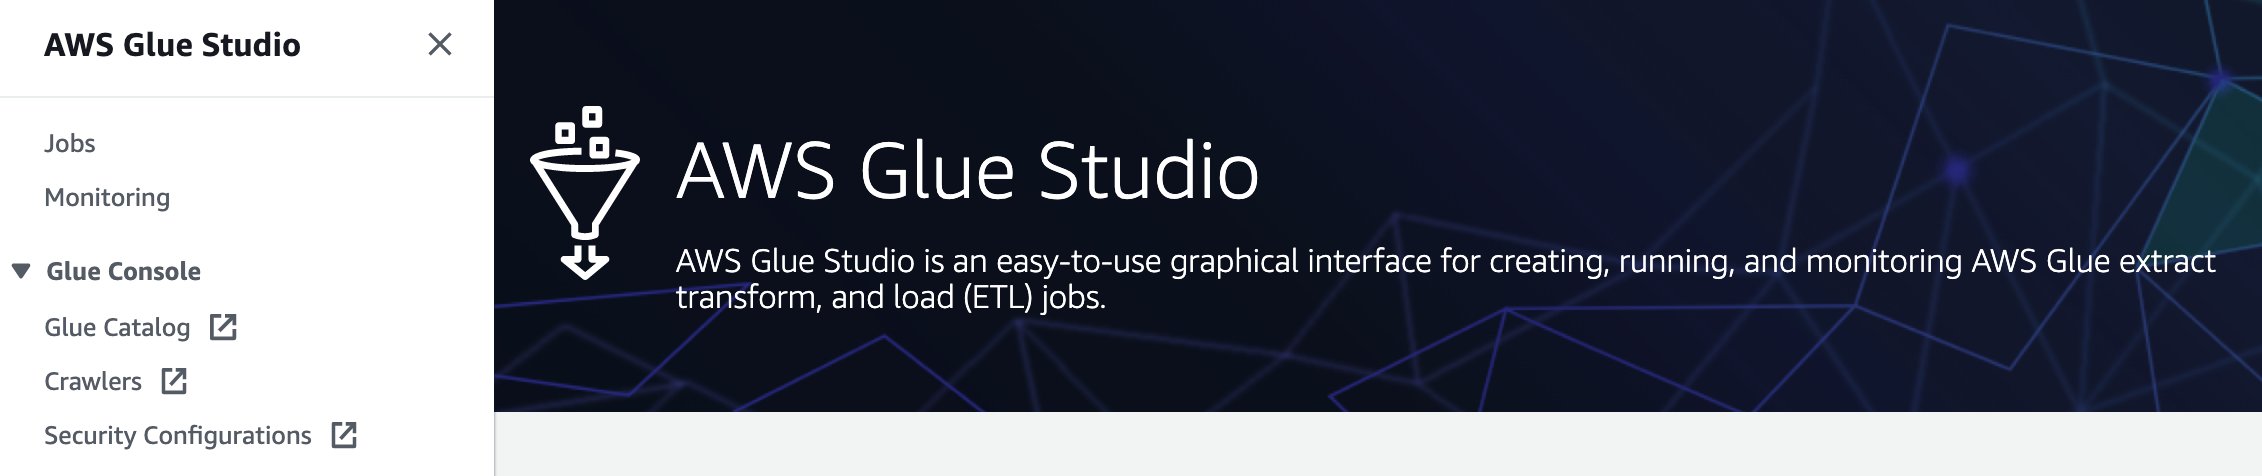

In [ ]:
df = pd.DataFrame(["https://console.aws.amazon.com/gluestudio/home?region={0}#/".format(region)])
df.columns = ['Link']
def make_clickable(val):
    return '<a href="{}" target="_blank">{}</a>'.format(val,val)

df.style.hide_index().format(make_clickable)

### Getting Started

To start visually building your ETL job you will click the `Jobs` link on the left hand pane. You can click the
<img src="images/hamburger-icon.png" width="20"> icon if the window is closed.

On the `Jobs` screen select the `blank job` radio butyon and then click the `Create` button.

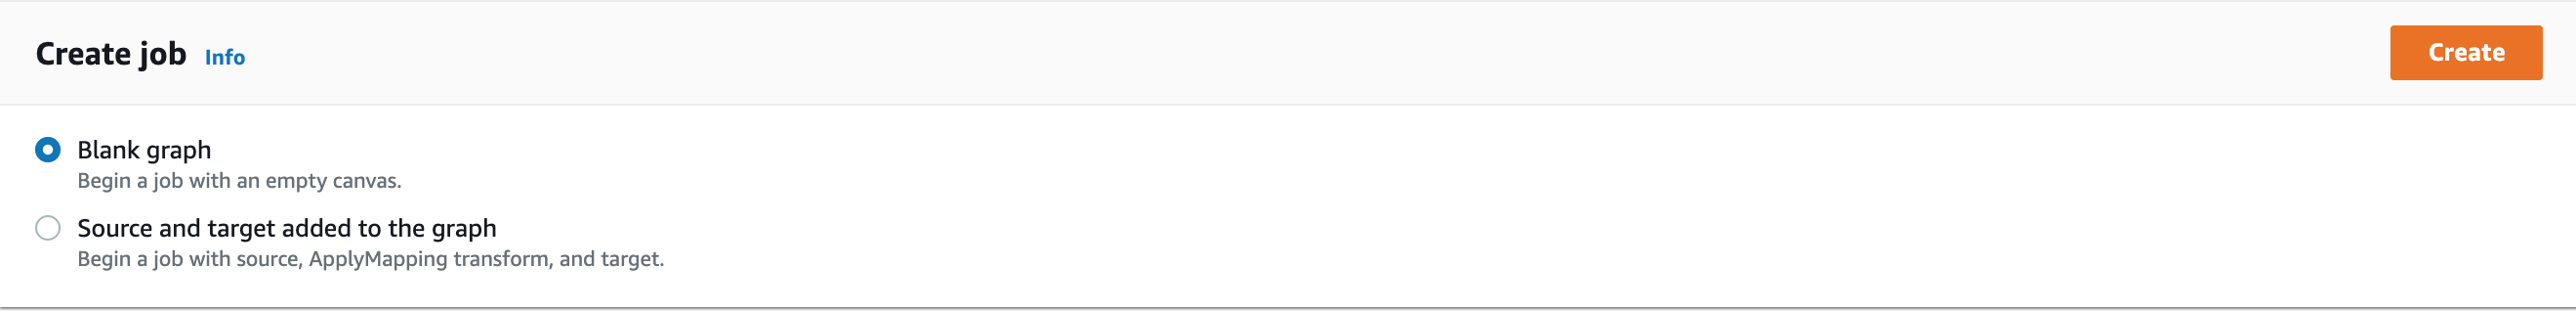
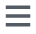

#### Familiarize yourself with the UI

<img src="images/initial-job-screen.png" width="400" style="float: left;padding-right: 10px"> You will come into the blank job screen and you will see a ribbon above the editor area containing key information. You have the `Visual` from the creation of each step of the job, the `Script` section that will be auto-generated in with **Python** or **Scala** depending on the job properties, the `Job Details` conataining the configuration of the job i.e. how many DPUs, Language, Version, etc., and finally you have the `Run Details` that will provide you the information on each run.

To get started click the <img src="images/plus-icon.png" width="40"> to create the first node of the job.
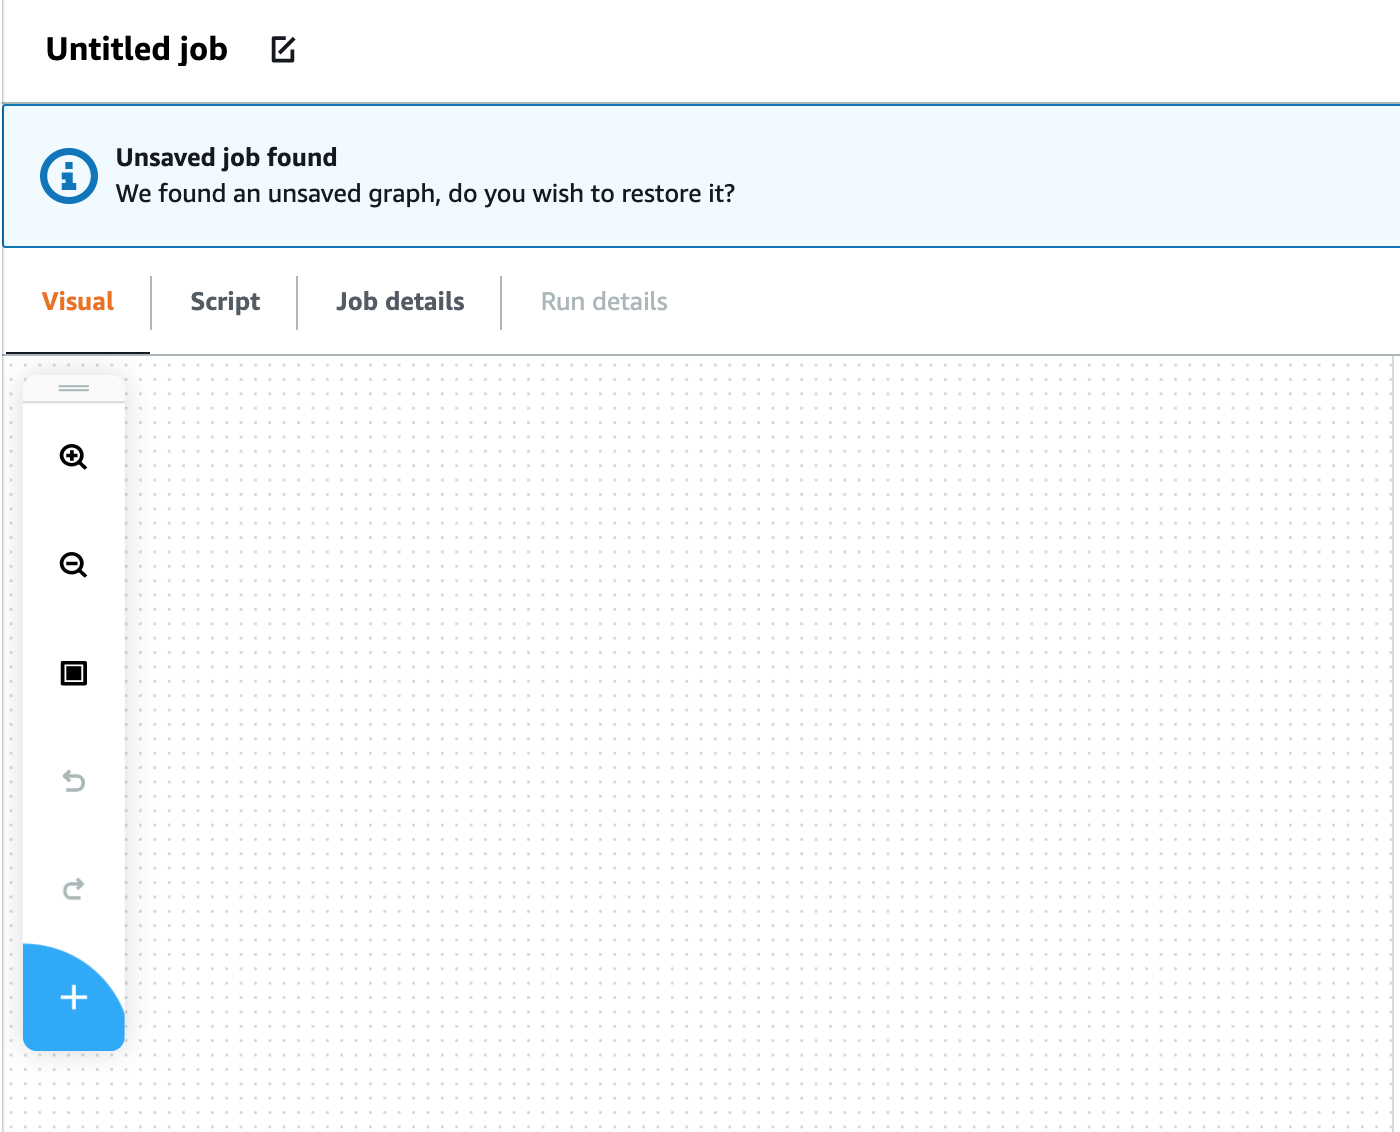
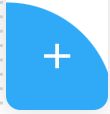

### Create Datasources for Yellow and PaymentCode tables

Choose the Node properties tab in the node details panel, then enter the following information:

* Name: Enter a name to associate with the node in the job graph. i.e. `Yellow Taxi Data`

* Node type: The node type determines the action performed by the node. In the list of options for Node type, choose under Data Sources `S3` type.

**A table for the source type that you choose must exist in the AWS Glue Data Catalog. AWS Glue Studio does not create the table.**

<img src="images/yellow-node-props.png" width="800" style="float: left;padding-right: 10px">

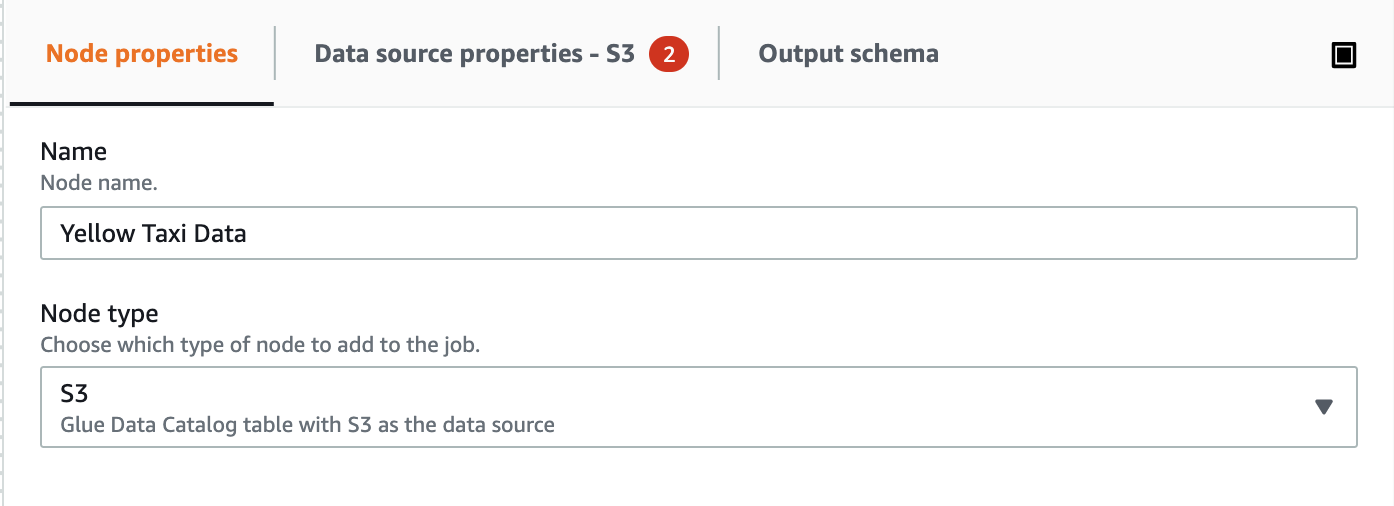

Next, us the `Database` and `Table` values created in the Glue Data Catalog from the Glue Crawler.

Choose the Data Source Properties tab, and then enter the following information:

* Database: `taxi_demo`

* Table: `yellow`

* Partition predicate (Optional): Enter a Boolean expression based on Spark SQL that includes only the partitioning columns. For example: "(year=='2020' and month=='04')". **Not used in this demo.**

<img src="images/yellow-data-props.png" width="800" style="float: left;padding-right: 10px">
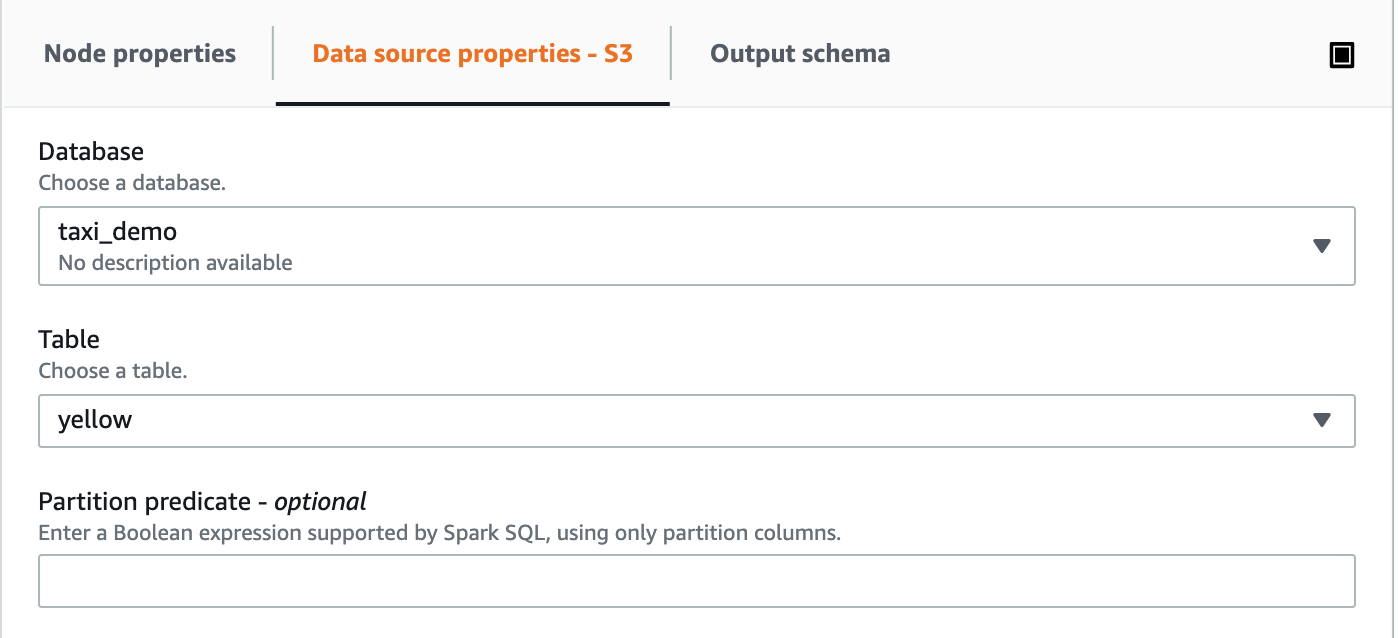

Repeat the steps above for the `paymenttype` table in the Glue Data Catalog

<img src="images/payment-type-node-props.png" width="800" style="float: left;padding-right: 10px">

<img src="images/payment-type-data-props.png" width="800" style="float: left;padding-right: 10px">

### Join the tables together

Next, let's join the tables together to get the rate code name into the data set. Click the plus icon to add a new `Node`. This time instead of choosing a `Data Source` choose the `Join` node in the `Transform` section of the drop-down. Fill in the fields like the image below.

<img src="images/join-node-props.png" width="800" style="float: left;padding-right: 10px">

In the `Transform` panel we have new fields based on the transform we are using. For the `Join` transform we require 2 parent nodes and the `Join Type`. These join types are similar to SQL join types. You also need to fill in the join condition. This informs the Glue job how to join the two data sources together. For this exercise we will join the ids together from the data sources like below.

For more information on joins go [here](https://docs.aws.amazon.com/glue/latest/ug/edit-nodes-chapter.html#transforms-configure-join).

<img src="images/join-transform.png" width="800" style="float: left;padding-right: 10px">

### Remap fields in the data set with an Apply Mapping

An [ApplyMapping](https://docs.aws.amazon.com/glue/latest/ug/edit-nodes-chapter.html#transforms-configure-appplymapping) transform remaps the source data property keys into the desired keys configured for the target data.

Select the `Join the Yellow and Payment Code Types` node as the parent node and `ApplyMapping` transform in the `Node Properties` panel.

<img src="images/apply-node-props.png" width="800" style="float: left;padding-right: 10px">

In the `Transform` panel clean up the keys by adding `_` in fields that don't separate words in the columns and rename the `name` field from the `payemnttype` table to `payemnt_type_name` and drop the `id` field as it was already conatined in the `yellow` data source as `payment_type`.

<img src="images/apply-transform.png" width="800" style="float: left;padding-right: 10px">


### Join the ratecode table

Following the steps above like for the `yellow` and `paymenttype` tables join the `ratecode` table to the `ApplyMapping` node. First, you will need to add the `ratecode` data source and then create the `Join` node afterwards joining the `ratecode` table.

<img src="images/rate-code-node-props.png" width="800" style="float: left;padding-right: 10px">

<img src="images/rate-code-data-props.png" width="800" style="float: left;padding-right: 10px">

Create the `Join` node type for the `ratecode` and `ApplyMapping` nodes.

<img src="images/join-rate-code-node-props.png" width="800" style="float: left;padding-right: 10px">

Use a `LeftJoin` on these tables with `rate_code_id` from the `ApplyMapping` node and `id` from the `ratecode` data source.

<img src="images/join-rate-code-transform.png" width="800" style="float: left;padding-right: 10px">

### Select fields from the joined data

Let's try another transform available the `SelectFields` transform to limit the number of columns we are working with typically based on the business workload need.

<img src="images/select-fields-node-props.png" width="800" style="float: left;padding-right: 10px">

#### For this example, let's use the following fields:

<img src="images/select-fields-transform.png" width="600" style="float: left;padding-right: 30px">

* vendor_id
* tpep_pickup_datetime
* tpep_dropoff_datetime
* trip_distance
* rate_code_id
* payment_type
* fare_amount
* tip_amount
* tolls_amount
* total_amount
* name (This is the name from the `ratecode` table we just joined)

### ApplyMapping update `ratecode` name

Let's create another `ApplyMapping` transform node to change the key of the `name` field to `rate_code_name`

<img src="images/fix-rate-code-node-props.png" width="600" style="float: left;padding-right: 30px">

<img src="images/fix-rate-code-transform.png" width="600" style="float: left;padding-right: 30px">

### Write data to S3 in Parquet format

Follow the same pattern of creating a new node in the job create a `DataTarget S3` node type.

<img src="images/save-parquet-node-props.png" width="600" style="float: left;padding-right: 30px">

In the data properties select the S3 bucket from the CloudFormation outputs above and put it in a `p_taxi_fares` prefix and select the `Parquet` format and no compression.

<img src="images/save-parquet-data-props.png" width="600" style="float: left;padding-right: 30px">

### Glue Job created!!!!

This should be the last step in you Glue Studio job. You can click the `Save` button at the top left corner. Your job should look similiar to the image below:

<img src="images/final-result.png" width="1200" style="float: left;padding-right: 30px">

### Configure the Job Details

Now that you have the flow created, you need to define a few details in order to run the job. You need to give the job a unique `Name`, optional `Description`, and `IAM Role` for the job. For the `IAM Role` choose from the drop down the role defined above in the CloudFormation Outputs. To better understand the options available follow the link [here](https://docs.aws.amazon.com/glue/latest/ug/managing-jobs-chapter.html#edit-jobs-properties).

<img src="images/job-detail-1.png" width="1200" style="float: left;padding-right: 30px">

### Build Glue Workflow to run job and run crawler

Now let's see how we can put this all together. We can use a Glue Workflow that is triggered on-demand when new data lands into the `yellow` prefix in the S3 bucket we are working in. Let's start by creating the Glue Workflow.

In [ ]:
job_name = 'TaxiDemoScript' # change this to the name of your Glue Studio created job

response = glue.create_workflow(
    Name='TaxiFareParquetConversionWorkflow',
    Description='Create taxi fare parquet dataset'
)
glue_workflow = response['Name']
print(glue_workflow)

response = glue.create_trigger(
    Name='Update_Catalog',
    WorkflowName=glue_workflow,
    Type='ON_DEMAND',
    Actions=[{'CrawlerName': data_crawler }]
)

response = glue.create_trigger(
    Name='Build_Taxi_Fares',
    WorkflowName=glue_workflow,
    Type='CONDITIONAL',
    StartOnCreation=True,
    Actions=[{'JobName': job_name}],
    Predicate= {'Logical': 'ANY',
        'Conditions': [
            {'LogicalOperator': 'EQUALS',
             'CrawlerName': data_crawler,
             'CrawlState': 'SUCCEEDED'}]
    }
)

response = glue.create_trigger(
    Name='Update_Catalog_After_Job',
    WorkflowName=glue_workflow,
    Type='CONDITIONAL',
    Actions=[{'CrawlerName': data_crawler}],
    Predicate= {'Logical': 'ANY',
        'Conditions': [
            {'LogicalOperator': 'EQUALS',
             'JobName': job_name,
             'State': 'SUCCEEDED'}]
    }
)

In [ ]:
print("https://console.aws.amazon.com/glue/home?region={0}#etl:tab=workflows".format(region))

### Glue Workflow

<img src="images/glue-workflow.png" width="1200" style="float: left;padding-right: 30px">